In [291]:
import requests
import os
import math
from sentence_splitter import SentenceSplitter
from threading import RLock, Thread
import matplotlib.pyplot as plt

In [105]:
bill_filenames = []
for file in os.listdir("../ustawy"):
    if file.endswith(".txt"):
        bill_filenames.append(os.path.join("../ustawy", file))

In [177]:
bills = []

In [178]:
for bill_name in bill_filenames:
    with open(bill_name, encoding='utf-8') as b_file:
        content = b_file.read()
        bills.append((len(content), content, bill_name))

In [179]:
bills = sorted(bills, key=lambda bill: -bill[0])

In [185]:
top50_bills = list(map(lambda bill: bill[1], bills[:50]))
top50_bills_names = list(map(lambda bill: bill[2], bills[:50]))

In [110]:
splitter = SentenceSplitter(language='pl')

In [171]:
def findBigletterSeqs(sentence: list):
    seqs = []
    concat = False
    seq = None
    for word in sentence:
        if not word.isalpha():
            concat = False
        else:
            if word[0].isupper():
                if concat:
                    seq += ' ' + word
                else:
                    seq = word
                    concat = True
            else:
                if seq is not None:
                    seqs.append(seq)
                    concat = False
                    seq = None
    if seq is not None:
        seqs.append(seq)
    return seqs

def seqsToBasicForm(bigLetterSeqs: list):
    basicFormSeqs = []
    for seq in bigLetterSeqs:
        res = requests.post('http://localhost:9200', data=seq.encode('UTF-8')).text
        lines = res.splitlines()
        basic = None
        for line in lines:
            line = line.split()
            if len(line) == 3:
                word = line[0]
                word = word.capitalize()
                tag = line[1].split(':')[0]
                key = (word, tag)
                if basic is None:
                    basic = word
                else:
                    basic += ' ' + word
        basicFormSeqs.append(basic)
                    
    return basicFormSeqs

lock = RLock()
def makeBigLetterSeqs(fromB, toB, port):
    for bill in top50_bills[fromB:toB]:
        sentences = splitter.split(text=bill.replace('\n', ' '))
        for sentence in sentences:
            sentence = sentence[:-1]
            sentence_words = sentence.split(' ')
            sentence_words = sentence_words[1:]
            bigLetterSeqs = findBigletterSeqs(sentence_words)
            bigLetterSeqs = seqsToBasicForm(bigLetterSeqs, port)
            with lock:
                for seq in bigLetterSeqs:
                    bilLetterExpr[seq] = bilLetterExpr.get(seq, 0) + 1

In [172]:
bilLetterExpr = {}

In [ ]:
t1 = Thread(target=makeBigLetterSeqs, args=(0, 25, '9200'))
t2 = Thread(target=makeBigLetterSeqs, args=(25, -1, '9201'))
t1.start()
t2.start()

In [173]:
for bill in top50_bills:
    sentences = splitter.split(text=bill.replace('\n', ' '))
    for sentence in sentences:
        sentence = sentence[:-1]
        sentence_words = sentence.split(' ')
        sentence_words = sentence_words[1:]
        bigLetterSeqs = findBigletterSeqs(sentence_words)
        bigLetterSeqs = seqsToBasicForm(bigLetterSeqs)
        for seq in bigLetterSeqs:
            bilLetterExpr[seq] = bilLetterExpr.get(seq, 0) + 1

In [174]:
bilLetterExpr_c = bilLetterExpr

In [175]:
bilLetterExpr = {k: v for k, v in sorted(bilLetterExpr.items(), key=lambda kv: kv[1], reverse=True)}

In [176]:
for expr, freq in list(bilLetterExpr.items())[:50]:
    print(f'{expr}: {freq}')

Numer: 3373
Kodeks: 508
Rzeczpospolita Polski: 442
Prawo: 319
Minister: 280
Rzeczpospolita: 275
Skarb Państwo: 251
Rada: 226
Policja: 220
Rada Minister: 210
Kasa Chory: 202
Unia Europejski: 201
Zmiana: 194
Azot: 164
Państwowy Komisja Wyborczy: 159
Zakład: 158
Skarb: 154
Pozostały: 153
Prezes Urząd: 151
Fundusz: 150
Urząd Patentowy: 148
Straż Graniczny: 143
Tkanina: 141
Państwowy Straż Pożarny: 139
Urząd: 119
Sprawiedliwość: 114
Ii: 112
Minister Sprawiedliwość: 110
Komisja: 106
Kasa: 102
Finanse: 99
Przepis: 99
Iii: 94
Damski: 93
Prezes: 92
Ordynacja: 92
Biuro: 92
Europejski Porozumienie: 92
Nawóz: 91
Wolny Handel: 90
Obrona Narodowy: 89
Unia: 87
Straż: 85
I: 81
Minister Obrona Narodowy: 80
Inspektor Nadzór Wewnętrzny: 80
Państwowy Straż: 79
Urz: 79
Prezes Rada Minister: 76
Sejm: 75


# Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model

In [288]:
import json
import time
import requests
import threading

clarinpl_url = "http://ws.clarin-pl.eu/nlprest2/base"
user = 'jg@gmail.com'
out_path = './out/'


def upload(bill):
    r = requests.post(url=clarinpl_url + '/startTask',
                             json={
                                 'text': bill,
                                 'lpmn': lpmn,
                                 'user': user,
                             })
    return r.content.decode("utf-8")


def process(task_id, bill_name):
    processing = True
    file_id = None

    while processing:
        data = requests.get(clarinpl_url + "/getStatus/" + task_id).text
        result = json.loads(data)
        end = time.time()
        if result["status"] == "PROCESSING":
            time.sleep(1)
        elif result["status"] == "DONE":
            file_id = result["value"][0]["fileID"]
            processing = False  
        else:
            print("ERROR:")
            print(data)
            processing = False  
    print(f'Result for {bill_name}, file id: {file_id}')
    data = json.loads(data)
    data=data['value'][0]["fileID"];
    content = requests.get(url+'/download'+data).content.decode("utf-8");
    with open(out_path + bill_name + '.ccl', "w",encoding='utf-8', errors='ignore') as outfile:
        outfile.write(content)
    
    
def worker(bill, bill_name):
    task_id = upload(bill)
    process(task_id, bill_name)

threads = []
for _, bill, bill_name in bills[:1]:
    bill_name = bill_name[10:-4]
    t = threading.Thread(target=worker, args=(bill, bill_name))
    threads.append(t)
    t.start()
    
for thread in threads:
    thread.join()     

Result for 2000_696, file id: /requests/liner2/799071ad-a3a7-4552-9926-a9209336e5ec


In [266]:
# z przykładu podanego przez bibliotekę:
# https://github.com/CLARIN-PL/NlpRest2-Tutorials

import xml.etree.ElementTree as ET

class Token:
    
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self):
        return self.orth
    
    def get_base(self):
        return self.base
    
    def get_ctag(self):
        return self.ctag
        

class Annotation:
    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self):
        return self.category
    
    def get_tokens(self):
        return self.tokens
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])

    def get_base(self):
        return " ".join([token.get_base() for token in self.tokens])
    
    def get_ctag(self):
        return " ".join([token.get_ctag() for token in self.tokens])
    
    def get_space(self):
        return " ".join(["True" for token in self.tokens])
    
    def get_lemma(self):
        return self.lemma
    
    def set_lemma(self, lemma):
        self.lemma = lemma

    def __str__(self):
        return "[%s] %s" % (self.get_category(), self.get_lemma())

def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):            
            index = int(channel.text)
            chan = channel.attrib["chan"]            
            if index > 0:                
                channels.setdefault(chan, {}) \
                        .setdefault(index, []) \
                        .append(t)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations
                

def ccl_ner(file):
    tree = ET.parse(file)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations

In [299]:
CG_hist = {}
CG_class_spec_hist = {}
FG_hist = {}
FG_spec_hist = {}

In [ ]:
for _, bill, bill_name in bills[:50]:
    ccl = out_path + bill_name[10:-4] + '.ccl'
    print(ccl)
    annotations = ccl_ner(ccl)
    for annotation in annotations:
        category = annotation.get_category()
        ne = annotation.get_lemma()
        fg_cat = category
        category = category.split('_')
        cg_cat = category[0] + '_' + category[1]
        CG_hist[cg_cat] = CG_hist.get(cg_cat, 0) + 1
        FG_hist[fg_cat] = FG_hist.get(fg_cat, 0) + 1
        if cg_cat not in CG_class_spec_hist.keys():
            CG_class_spec_hist[cg_cat] = {}
        CG_class_spec_hist[cg_cat][ne] = CG_class_spec_hist[cg_cat].get(ne, 0) + 1
        FG_spec_hist[(ne, fg_cat)] = FG_spec_hist.get((ne, fg_cat), 0) + 1

# Histogram of the coares-grained classes

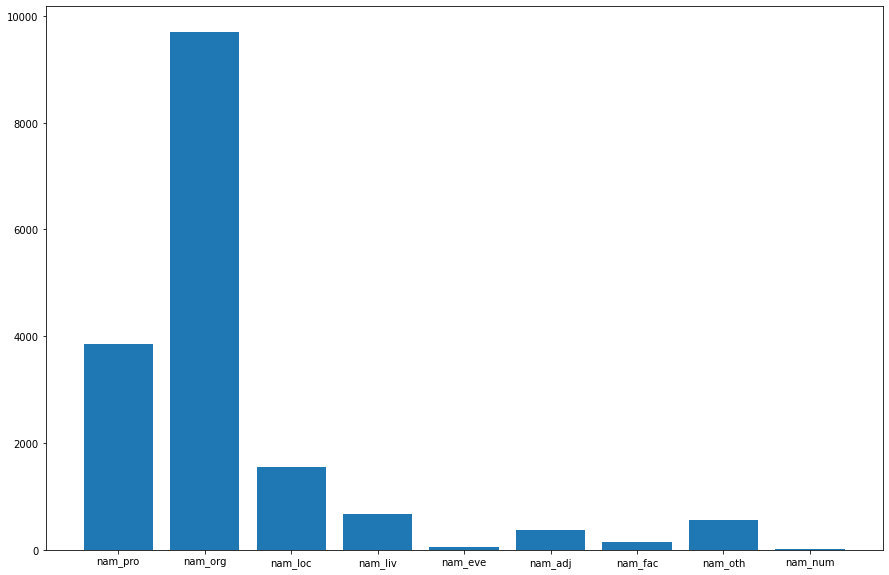

In [295]:
plt.figure(figsize=(15,10))
plt.bar(list(CG_hist.keys()), CG_hist.values())
plt.show()

# 10 most frequent Named Entities for each coarse-grained type

In [312]:
for cg, ne_freq in CG_class_spec_hist.items():
    print(cg)
    sorted_ne_freq = {k: v for k, v in sorted(ne_freq.items(), key=lambda kv: kv[1], reverse=True)}
    for ne, freq in list(sorted_ne_freq.items())[:10]:
        print(f'\t{freq}:\t{ne}')

nam_pro
	1577:	Dz . U .
	205:	Times
	90:	Times New Roman
	81:	Dz . Urz
	77:	Ordynacja podatkowa
	64:	Kodeksu karnego
	62:	Monitor Polski
	58:	Znak
	51:	Spraw Wewnętrznych
	35:	Kodeksu postępowania administracyjnego
nam_org
	302:	Unii Europejskiej
	291:	Skarbu Państwa
	261:	Rada Ministrów
	237:	Państwowej Straży Pożarnej
	232:	Minister Sprawiedliwości
	212:	Prezes Rady Ministrów
	154:	Minister Obrony Narodowej
	151:	Minister Finansów
	132:	Urzędu Ochrony Państwa
	114:	EFTA
nam_loc
	815:	Rzeczypospolitej Polskiej
	56:	Rzeczpospolita Polska
	51:	Polsce
	41:	Rzeczpospolitą Polską
	32:	Warszawie
	20:	Warszawy
	19:	Nawóz
	16:	Warszawa
	11:	Konfederacji Szwajcarskiej
	10:	Polską
nam_liv
	51:	Kasa Chorych
	36:	Straży Granicznej
	24:	Sił Zbrojnych
	21:	Kasy Chorych
	18:	Art
	18:	Pana
	16:	Gospodarki Żywnościowej
	15:	Krajowego Depozytu
	15:	Pan
	13:	Kas Chorych
nam_eve
	5:	EURO
	2:	Monitorze Sądowym
	2:	Adobe Fangsong Std R
	2:	Adobe Myungjo Std M
	2:	Przejściowego Planu Krajowego
	1:	Generalny

# 50 most frequent Named Entities for fine-grained type

In [316]:
sorted_FG_spec_hist = {k: v for k, v in sorted(FG_spec_hist.items(), key=lambda kv: kv[1], reverse=True)}
for (ne, fg_type), freq in list(sorted_FG_spec_hist.items())[:50]:
    print(f'{freq}:\t{fg_type}:\t{ne}')

1577:	nam_pro_media_periodic:	Dz . U .
815:	nam_loc_gpe_country:	Rzeczypospolitej Polskiej
301:	nam_org_organization:	Unii Europejskiej
293:	nam_oth_currency:	zł
291:	nam_org_institution:	Skarbu Państwa
261:	nam_org_institution:	Rada Ministrów
232:	nam_org_institution:	Minister Sprawiedliwości
212:	nam_org_institution:	Prezes Rady Ministrów
205:	nam_pro_media_periodic:	Times
203:	nam_org_organization:	Państwowej Straży Pożarnej
154:	nam_org_institution:	Minister Obrony Narodowej
151:	nam_org_institution:	Minister Finansów
132:	nam_org_institution:	Urzędu Ochrony Państwa
116:	nam_adj_country:	polski
114:	nam_org_organization:	EFTA
110:	nam_org_institution:	Państwowa Komisja Wyborcza
104:	nam_org_institution:	Urząd Patentowy
103:	nam_org_company:	Europejskiego Porozumienia o Wolnym Handlu
98:	nam_org_institution:	Skarb Państwa
98:	nam_org_institution:	Państwowej Komisji Wyborczej
90:	nam_oth_currency:	euro
88:	nam_pro_title:	Times New Roman
88:	nam_org_institution:	Prezes Urzędu
81:	nam_

# Answer the following questions:
## Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
Lepiej zadziałał NER, ale przydałoby się jego wyniki również poddać lematyzacji w celu usnięcia dużej liczby powtórzeń, jak np. dla klasy nam_adj większość przypadków to odmienione słowo Polska.  

## What are the drawbacks of the method based on capital letters?
Przy prostym podejściu jakie zastosowaliśmy pomijamy lub zniekształcamy wszystkie nazwy, które były na początku zdania. Drugim bardzo znaczącym minusem jest dzielenie nazw zawierających spójniki pisane małą literą lub inne słowa wystęjuce wewnątrz pisane z małej litery.

## What are the drawbacks of the method based on NER?
Jest zdecydowanie wolniejsze, użyty przez nas model miał aż 82 klasy co wydaje się dużó, dla tak prostych zadań lepiej według mnie użyć modelu z bardziej ogólnymi klasami.

## Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
Najlpiej NER poradził sobie z klasą _nam_org_ czyli z instytucjami, natomiast najgorzej z klasą _nam_num_ czyli z wyrażeniami liczbowymi co wynika wprost z ich liczby wystąpień, nazwy jak _Unia Europejska_ często powtarzały się w tekście, natomiast powtarzanie się konkretnych liczb w tekście było znacząco mniejsze.


## Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?
Nie jest wystarczający, ponieważ nie bierze w żaden sposób pod uwagę synonimów, tylko rozważa każdą formę z osobna jak dla _Rzeczpospolita Posla_ i _Polska_.

Wymagałoby to zlematyzowania wyników i użycia narzędzia jak chociażby _WordNet_, które pozwoliłoby je skonsolidować do jednej NE.


## Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
Myślę, że byłoby to bardzo przydatne chociażby w przeszukiwaniu o czym jest dany tekst, wystarczyłoby przetrzymwać tylko częste wystąpienia z wybranych klas i dałoby się na tej podstawie określić +/- temat.
